# Blog Post

Full description of the reasoning behind all the exclusions can be found at the blog post here:

https://www.lacework.com/blog/dealing-with-mitre

# Collect Data

In [32]:
import mitreattack.attackToExcel.attackToExcel as attackToExcel
import mitreattack.attackToExcel.stixToDf as stixToDf
from IPython.core.display import SVG

# download and parse ATT&CK STIX data
attack_data = attackToExcel.get_stix_data("enterprise-attack")

techniques_data = stixToDf.techniquesToDf(attack_data, "enterprise-attack")
techniques_df = techniques_data["techniques"]
techniques_df['tactics'] = techniques_df.tactics.str.split(", ")
techniques_df = techniques_df.explode('tactics')

2023-10-11 10:17:27.215 | INFO     | mitreattack.attackToExcel.attackToExcel:get_stix_data:69 - Downloading ATT&CK data from github.com/mitre/cti
parsing relationships for type=technique: 100%|██████████| 16530/16530 [00:00<00:00, 137793.93it/s]


# Setting Helper Functions

In [33]:
from mitreattack.navlayers import Layer, ToSvg, SVGConfig

def create_layer(technique_list, file_name):
    all_parents = list(set([(technique['ID'].split('.')[0], technique['tactics']) for technique in technique_list]))
    just_ids = set([technique['ID'] for technique in technique_list])

    techniques = [{
        "techniqueID": technique['ID'], 
        "tactic": technique['tactics'].lower().replace(' ', '-'), 
        "showSubtechniques": True, 
        "score": 1,
        "comment": "",
        "enabled": True
        } for technique in technique_list]

    for parent in all_parents:
        parent_id = parent[0]
        parent_tactic = parent[1]
        if parent_id not in just_ids: # If the parent is already in the list, don't override the parent
            techniques.append({
                "techniqueID": parent_id, 
                "tactic": parent_tactic.lower().replace(' ', '-'), 
                "showSubtechniques": True, 
                "score": 0, # parents are added to expand them, not to mark them as disabled
                "comment": "",
                "enabled": True
            })


    layer_dict = {
        "name": "Undetectable Sources",
        "versions" : {
            "attack": "13",
            "layer" : "4.3",
            "navigator": "4.3"
        },
        "domain": "enterprise-attack",
        "techniques": techniques,
        "selectSubtechniquesWithParent": True,
        "gradient": {
            "colors": [
                "#ffffff",
                "#000000",
            ],
            "minValue": 0,
            "maxValue": 1
        }
    }

    layerA = Layer()
    layerA.from_dict(layer_dict)
    layerA.to_file(f"layers/{file_name}.json")

    y = SVGConfig(width=16, height=11, headerHeight=1, unit="in", showSubtechniques="all",
                 font="sans-serif", tableBorderColor="#6B7279", showHeader=False, legendDocked=True,
                 legendX=0, legendY=0, legendWidth=2, legendHeight=1, showLegend=False, showFilters=False,
                 showAbout=True, showDomain=True, border=0.104)

    t = ToSvg(domain=layerA.layer.domain, source='local', resource='enterprise-attack-13.1.json', config=y)
    t.to_svg(layerInit=layerA, filepath=f"svg/{file_name}.svg")


# Get Techniques With No Data Sources
First, we start by filtering out techniques without any data sources. The reasoning is simple, if there are no data sources that report when a technique is seen, we cannot detect said technique. As you can see from the table below, all of the filtered techniques are from the Pre-ATT&CK matrix. 

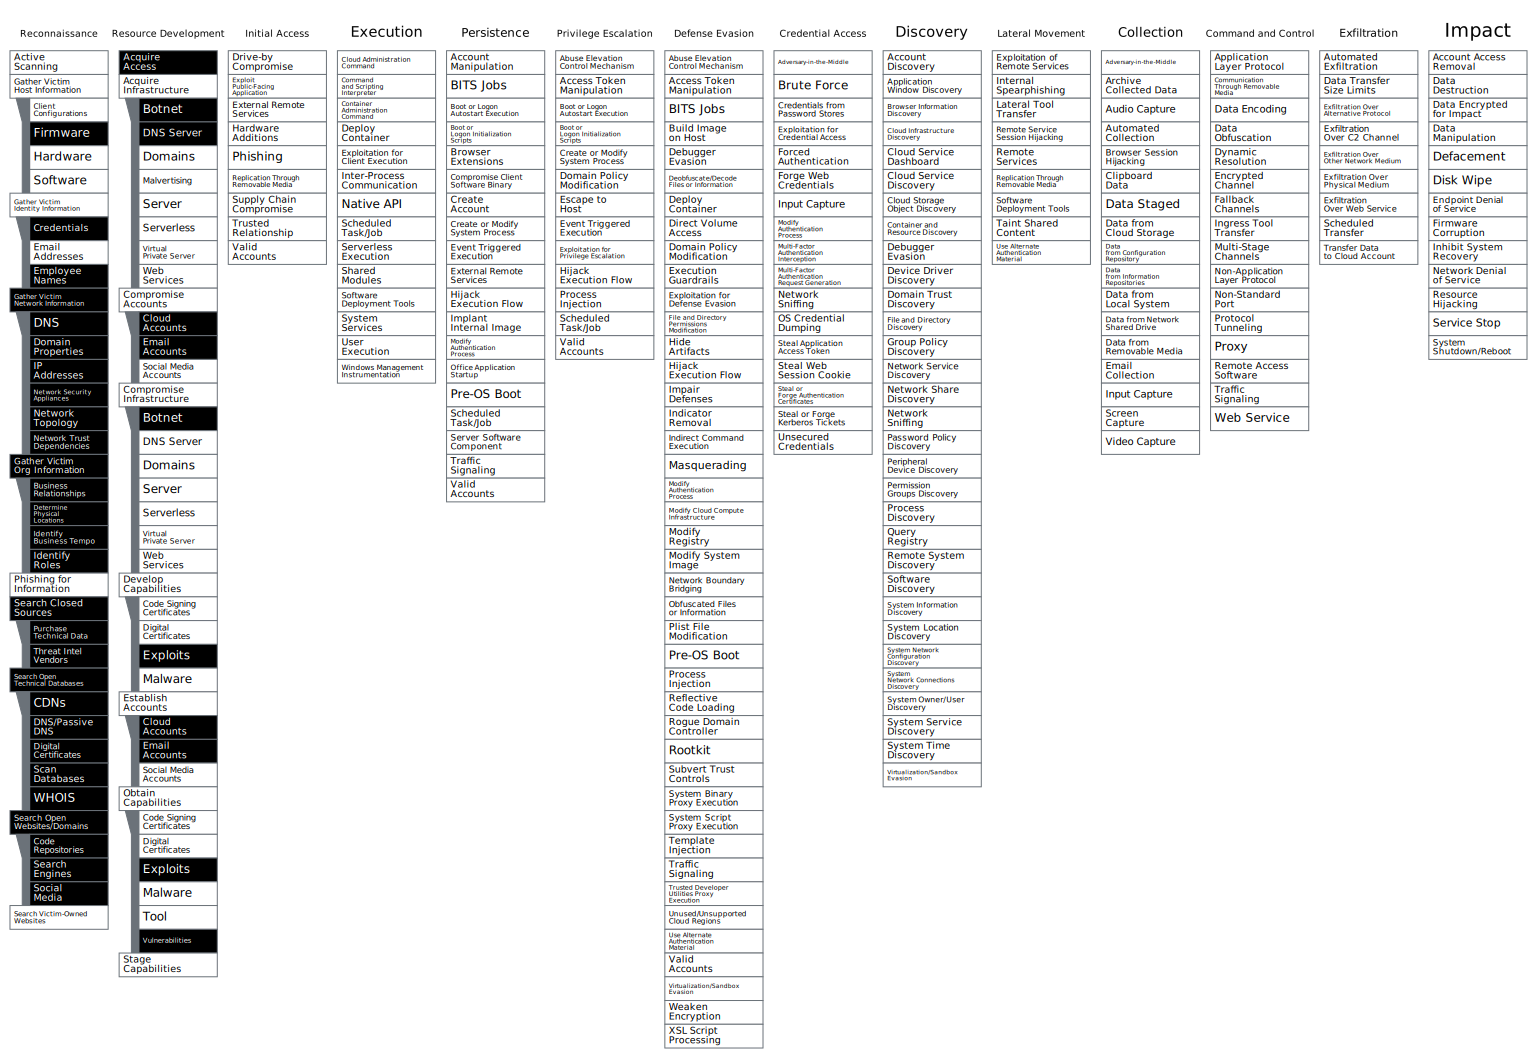

In [34]:
techniques_with_no_data_sources = techniques_df.query("`data sources`.isna()")[['ID', 'tactics']].to_dict('records')
create_layer(techniques_with_no_data_sources, "no_data_source")
SVG(filename='svg/no_data_source.svg')


# Techniques With Uncollectable Data Sources
Other techniques do have data sources, but those data sources require monitoring information on a global level. For example, the data source `Internet Scan: Response Content` implies that defenders should scan the whole internet looking for possible attacker infrastructures. Some level of this might be possible for larger organizations, but the reward for this remains limited, especially given that techniques involved are all in the Pre-ATT&CK matrix.

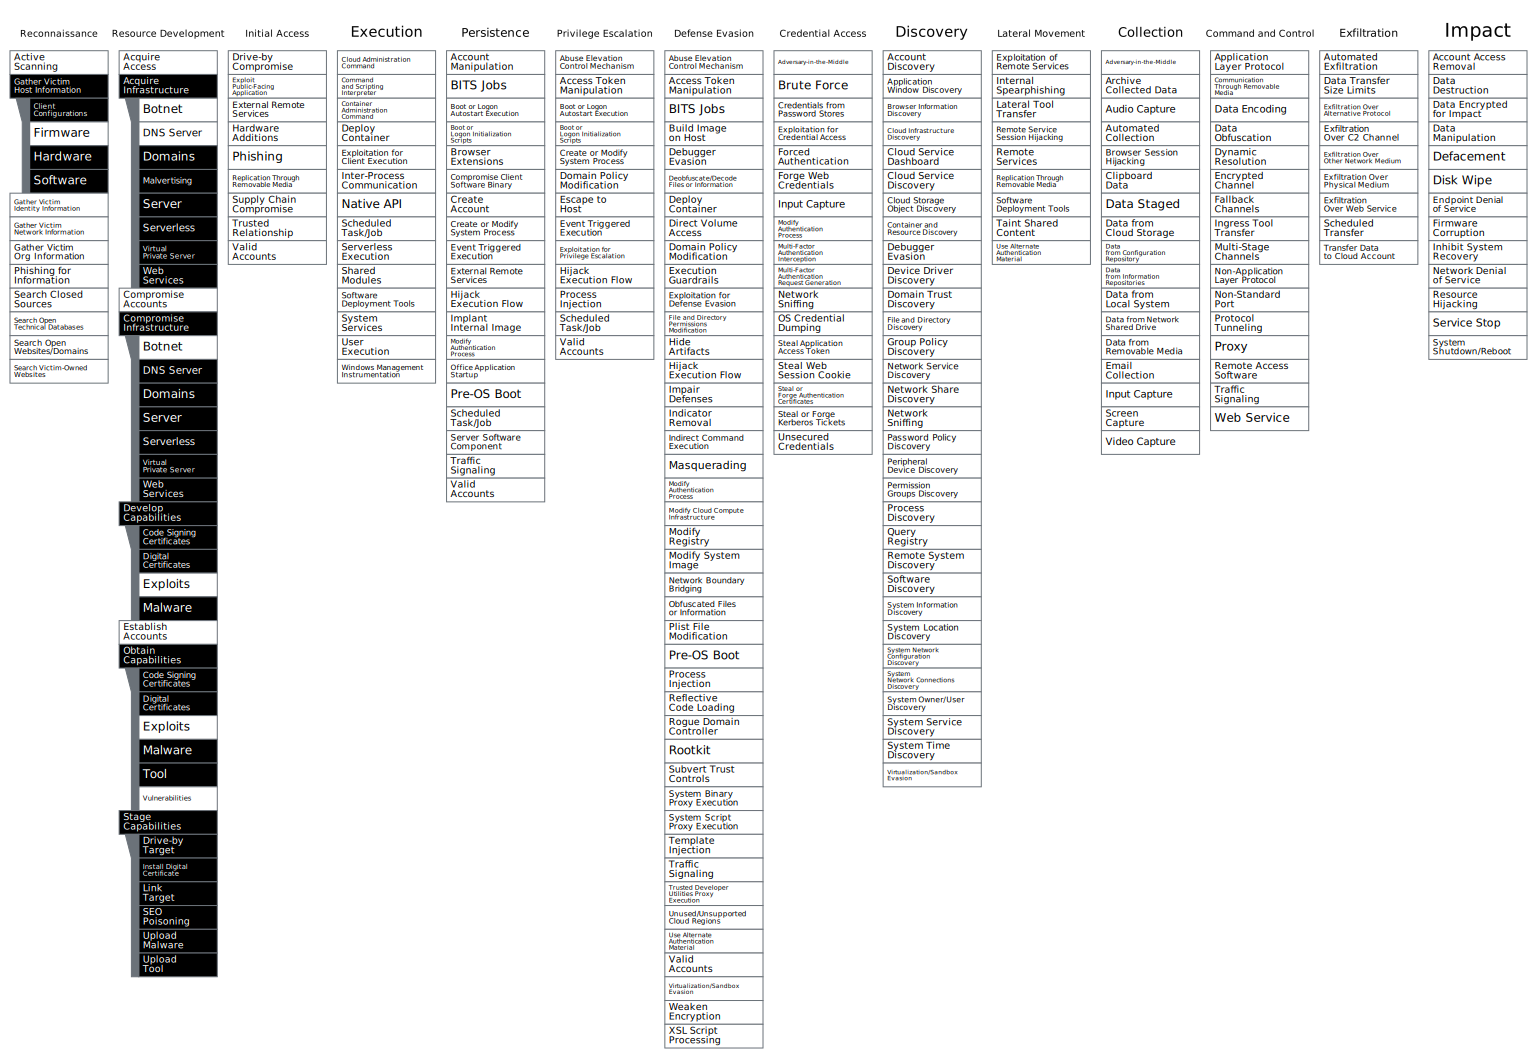

In [35]:
uncollectable_data_sources = [
    "Internet Scan: Response Content",       # Implies scanning all of the internet
    "Internet Scan: Response Metadata",      # Implies scanning all of the internet
    "Domain Name: Passive DNS",              # Implies monitoring all global DNS traffic
    "Domain Name: Active DNS",               # Implies monitoring all global DNS traffic
    "Domain Name: Domain Registration",      # Implies monitoring all domain registrations
    "Malware Repository: Malware Metadata",  # Implies monitoring all submissions to malware repos
    "Malware Repository: Malware Content",   # Implies monitoring all submissions to malware repos
    "Persona: Social Media",                 # Implies monitoring all social media sites and personas
    "Certificate: Certificate Registration", # Implies monitoring all certification registrations
]

def is_all_uncollectable_data_sources(data_sources):
    if isinstance(data_sources, float):
        return False
    data_sources = data_sources.split(',')
    data_sources = [source.strip() for source in data_sources]

    all_matching_sources = set(data_sources).issubset(uncollectable_data_sources)
    return all_matching_sources

techniques_df["is_all_uncollectable_data_sources"] = techniques_df["data sources"].map(is_all_uncollectable_data_sources)
techniques_with_uncollectable_data = techniques_df.query("is_all_uncollectable_data_sources == True")[['ID', 'tactics']].to_dict('records')

create_layer(techniques_with_uncollectable_data, "uncollectable_data_source")
SVG(filename='svg/uncollectable_data_source.svg')

# Firmware: Firmware Modification
While we are on the topic of data sources, we should highlight Firmware Modification. Despite being listed as a data source, Firmware Modifications are not usually collected centrally in a SIEM or similar solution. The reasoning for this is simple, if the attacker is at the point where they can modify the host firmware, you _really_ should not trust anything from that host. Firmware Modifications should be treated as a forensics data source rather than a detection one.

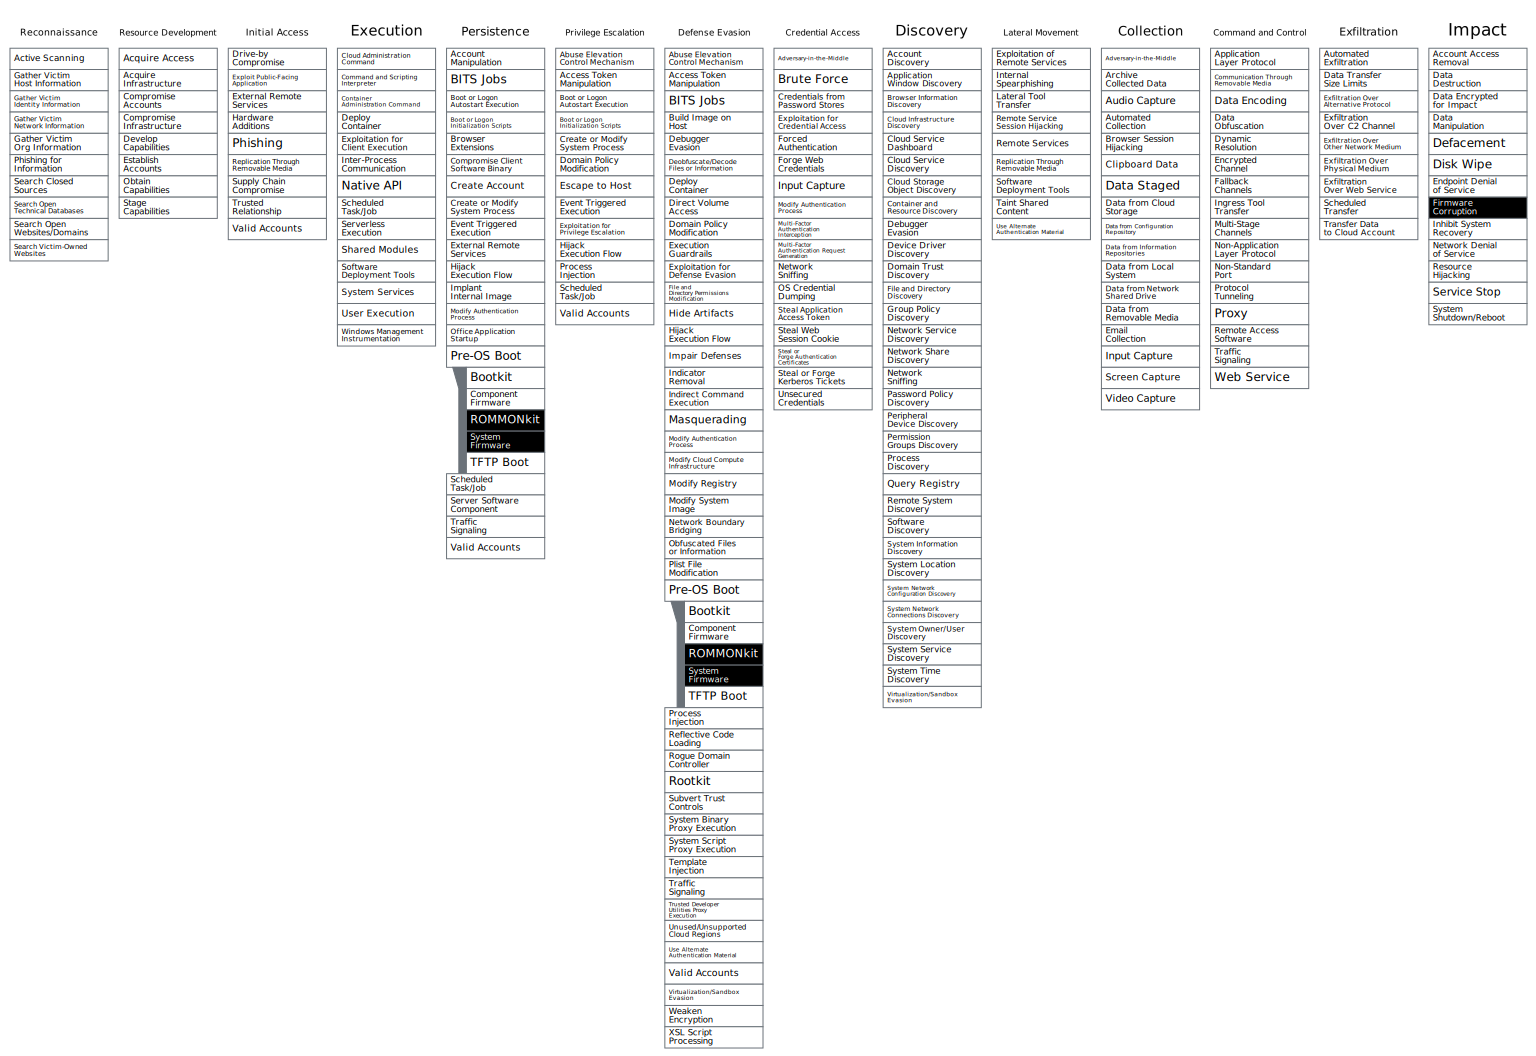

In [36]:
uncollectable_data_sources = [
    "Firmware: Firmware Modification"
]

def is_all_uncollectable_data_sources(data_sources):
    if isinstance(data_sources, float):
        return False
    data_sources = data_sources.split(',')
    data_sources = [source.strip() for source in data_sources]

    all_matching_sources = set(data_sources).issubset(uncollectable_data_sources)
    return all_matching_sources

techniques_df["firmware_techniques"] = techniques_df["data sources"].map(is_all_uncollectable_data_sources)
firmware_techniques = techniques_df.query("firmware_techniques == True")[['ID', 'tactics']].to_dict('records')

create_layer(firmware_techniques, "firmware_techniques")
SVG(filename='svg/firmware_techniques.svg')

# Phishing
Notice that T1598 (Phishing for Information) remains in the Pre-ATT&CK matrix. We consider this technique and its subtechniques to be detectable. That said, it is worth mentioning that there are three techniques for Phishing:
* T1598: Phishing for Information
* T1566: Phishing
* T1534: Internal Spearphishing

The distinction between these three has its uses like reporting on internal incidents, but from a detection standpoint, for the most part, Phishing can be considered a single technique. As such, we will only keep T1566 enabled and disable the other two.

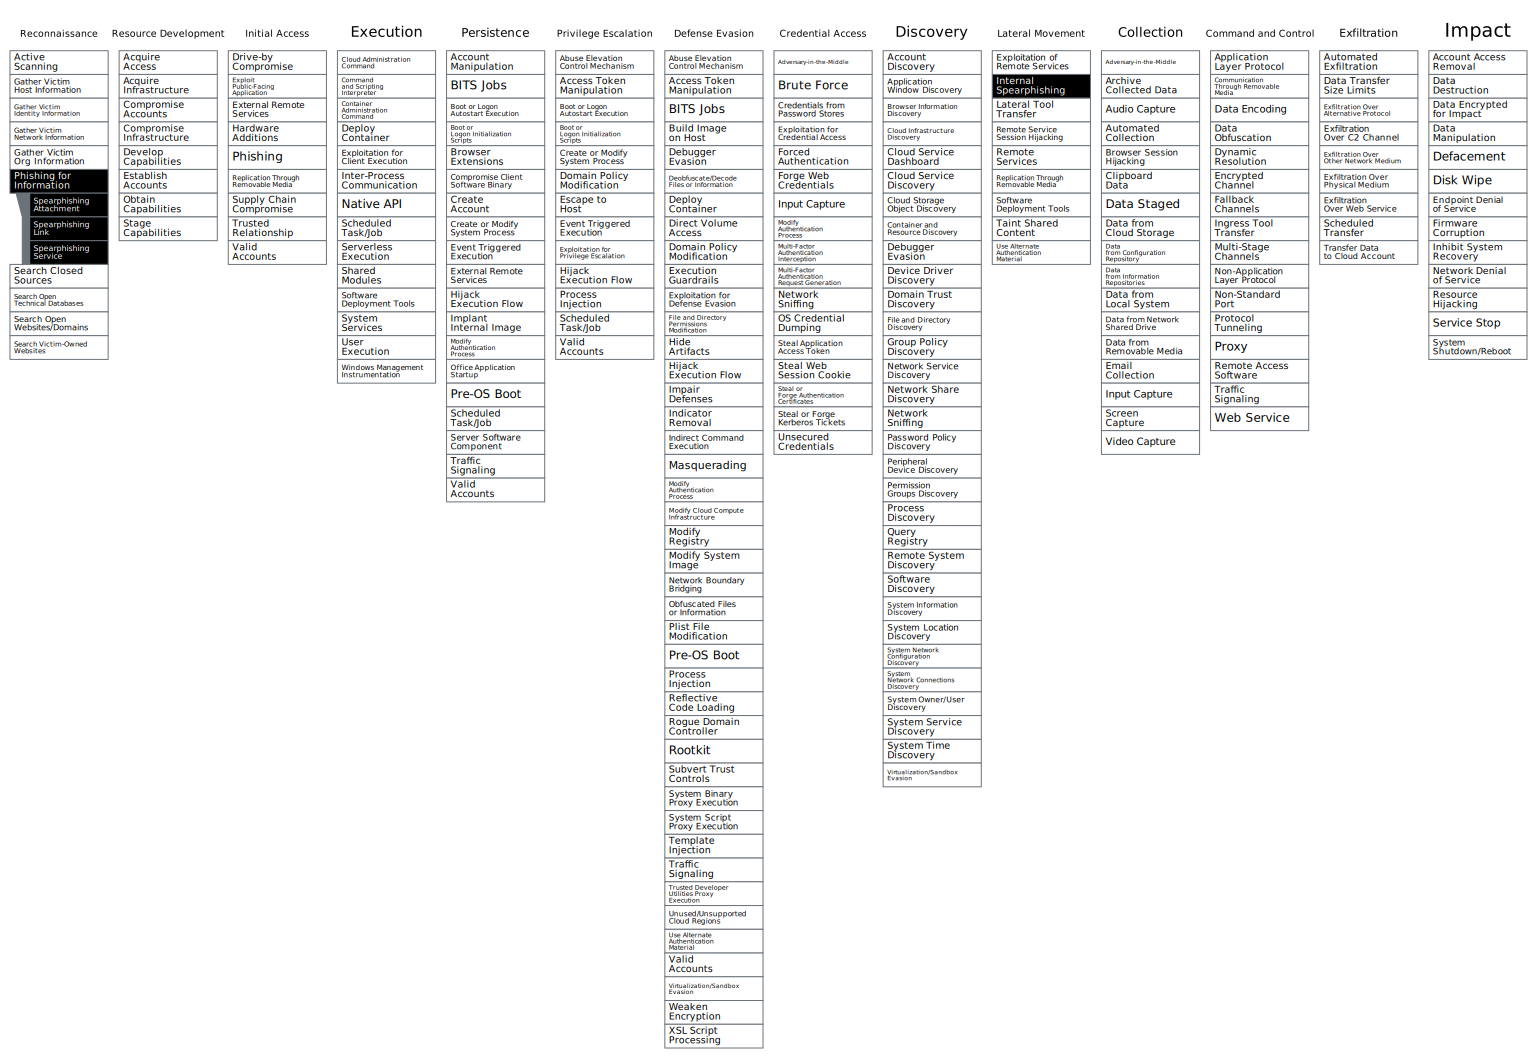

In [37]:
duplicated_phishing_techniques = [
    {'ID': 'T1598', 'tactics': 'Reconnaissance'},
    {'ID': 'T1598.001', 'tactics': 'Reconnaissance'},
    {'ID': 'T1598.002', 'tactics': 'Reconnaissance'},
    {'ID': 'T1598.003', 'tactics': 'Reconnaissance'},
    {'ID': 'T1534', 'tactics': 'Lateral Movement'},
]
create_layer(duplicated_phishing_techniques, "duplicated_phishing_techniques")
SVG(filename='svg/duplicated_phishing_techniques.svg')

# Detectable Techniques in Pre-ATT&CK
Three of the techniques left in Pre-ATT&CK are:
* Active Scanning
* Search Victim-Owned Websites
* VulnerabilityScanning

The first two should fall into the Trivial True Positives (TTP) bucket. That is, they can be detected, but the detection by itself is not that useful. The last one is a bit more interesting and should be detected.

We are leaving all these techniques as detectable.

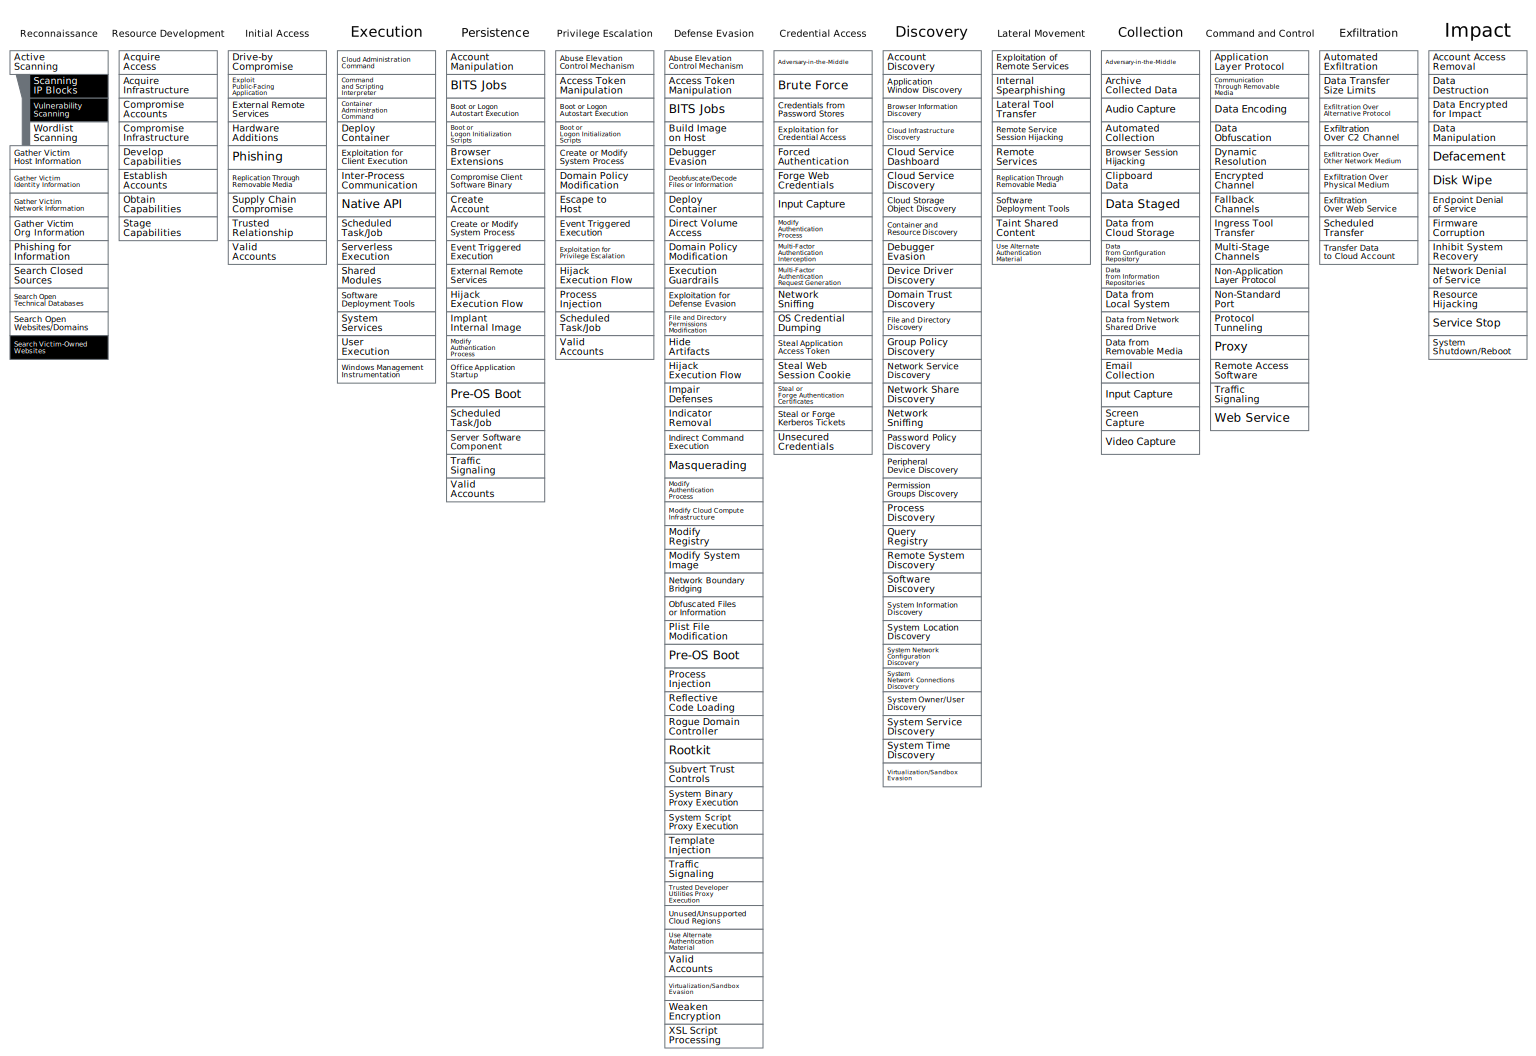

In [38]:
detectable_pre_attack = [
    {'ID': 'T1595.001', 'tactics': 'Reconnaissance'},
    {'ID': 'T1595.002', 'tactics': 'Reconnaissance'},
    {'ID': 'T1594', 'tactics': 'Reconnaissance'},
]
create_layer(detectable_pre_attack, "detectable_pre_attack")
SVG(filename='svg/detectable_pre_attack.svg')

# Network Traffic Content
With all the filtering we've done so far, we are left with the following techniques in Pre-ATT&CK:
* Gather Victim Identity Information
* Compromise Accounts

These techniques have `Network Traffic Content` as a data source. For demonstration, we'll consider `Network Traffic Content` as an uncollectable data source, similar to the list above. The reasoning is that the remaining techniques require capturing global traffic patterns (at least for Pre-ATT&CK).

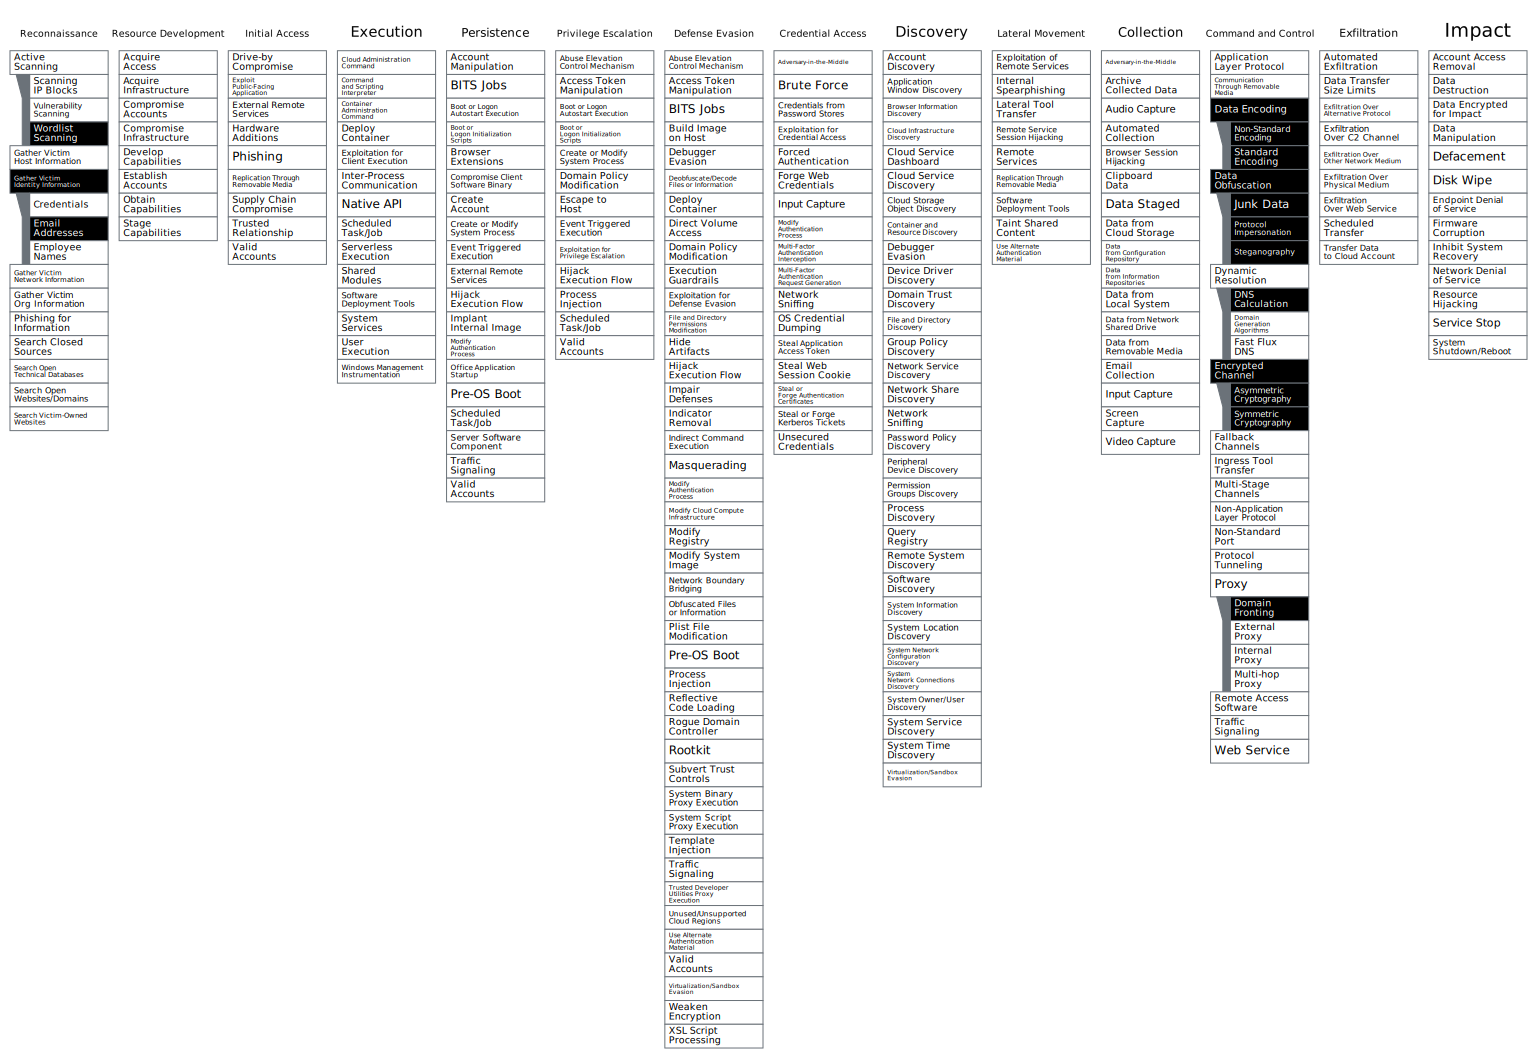

In [39]:
from copy import deepcopy

uncollectable_data_sources_plus_network_traffic = deepcopy(uncollectable_data_sources)
uncollectable_data_sources_plus_network_traffic.append('Network Traffic: Network Traffic Content')

def is_all_uncollectable_data_sources(data_sources):
    if isinstance(data_sources, float):
        return False
    if not 'Network Traffic: Network Traffic Content' in data_sources:
        return False
    data_sources = data_sources.split(',')
    data_sources = [source.strip() for source in data_sources]

    all_matching_sources = set(data_sources).issubset(uncollectable_data_sources_plus_network_traffic)
    return all_matching_sources

techniques_df["is_all_uncollectable_data_sources"] = techniques_df["data sources"].map(is_all_uncollectable_data_sources)
techniques_with_uncollectable_data_plus_network_traffic = techniques_df.query("is_all_uncollectable_data_sources == True")[['ID', 'tactics']].to_dict('records')

create_layer(techniques_with_uncollectable_data_plus_network_traffic, "techniques_with_uncollectable_data_plus_network_traffic")
SVG(filename='svg/techniques_with_uncollectable_data_plus_network_traffic.svg')

With this, we cover all of Pre-ATT&CK using only the data sources. That said, considering `Network Traffic Content` to be an unusable data source also gave us the following techniques and their sub-techniques:
* Data Obfuscation:
    * Junk Data
    * Protocol Impersonation
    * Steganography
* Proxy:
    * Domain Fronting
* Dynamic Resolution:
    * DNS Calculation
* Data Encoding:
    * Non-Standard Encoding
    * Standard Encoding
* Encrypted Channel:
    * Symmetric Cryptography
    * Asymmetric Cryptography

`Data Obfuscation` specifies an action. Attackers may choose to use `Junk Data`, `Protocol Impersonation`, or `Steganography`; and there are different Procedures for how they can do any of the Techniques listed above. Same goes for `Proxy: Domain Fronting` and `Dynamic Resolution: DNS Calculation`.

The last two techniques are different from the rest. `Data Encoding` with its two sub-techniques cover the entirety of everything that has ever been put on to a network. Non-Standard Encoding, however, represents an aberation. So if an attacker uses a specific non-standard encoding, we might be able to detect it.  

`Encrypted Channel` covers all encrypted traffic on a network. That is, they do not help narrow down any specific Procedure that the attackers might use because the Technique covers the entirety of everything going on the network.

As such, We will keep `Data Encoding: Standard Encoding` and `Encrypted Channel` as undetectable but remove the rest from the list.

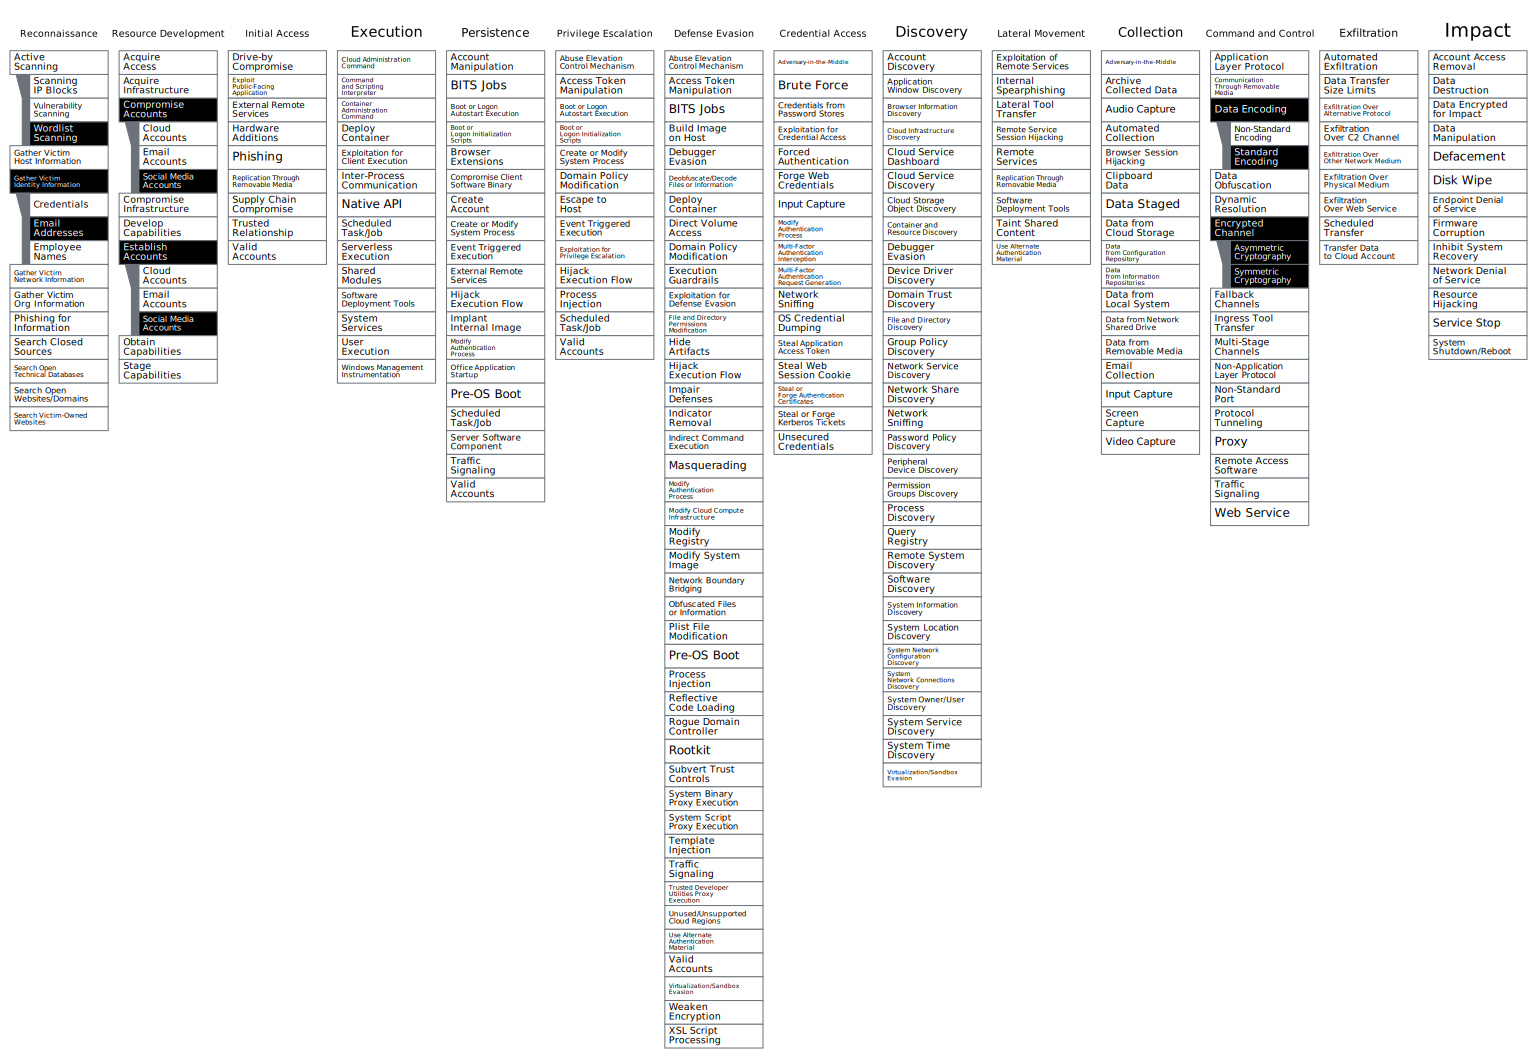

In [40]:
network_traffic_content_techniques = [
{
    'ID': 'T1595.003',
    'name': 'Active Scanning: Wordlist Scanning',
    'tactics': 'Reconnaissance'
},
{
    'ID': 'T1586',
    'name': 'Compromise Accounts',
    'tactics': 'Resource Development'
},
{
    'ID': 'T1586.001',
    'name': 'Compromise Accounts: Social Media Accounts',
    'tactics': 'Resource Development'
},
{
    'ID': 'T1132', 
    'name': 'Data Encoding', 
    'tactics': 'Command and Control'
},
{
    'ID': 'T1132.001',
    'name': 'Data Encoding: Standard Encoding',
    'tactics': 'Command and Control'
},
{
    'ID': 'T1573',
    'name': 'Encrypted Channel',
    'tactics': 'Command and Control'
},
{
    'ID': 'T1573.002',
    'name': 'Encrypted Channel: Asymmetric Cryptography',
    'tactics': 'Command and Control'
},
{
    'ID': 'T1573.001',
    'name': 'Encrypted Channel: Symmetric Cryptography',
    'tactics': 'Command and Control'
},
{
    'ID': 'T1585',
    'name': 'Establish Accounts',
    'tactics': 'Resource Development'
},
{
    'ID': 'T1585.001',
    'name': 'Establish Accounts: Social Media Accounts',
    'tactics': 'Resource Development'
},
{
    'ID': 'T1589',
    'name': 'Gather Victim Identity Information',
    'tactics': 'Reconnaissance'
},
{
    'ID': 'T1589.002',
    'name': 'Gather Victim Identity Information: Email Addresses',
    'tactics': 'Reconnaissance'
}]
create_layer(network_traffic_content_techniques, "network_traffic_content_techniques")
SVG(filename='svg/network_traffic_content_techniques.svg')

# Valid Accounts

Technically, no action can be taken on any system without the use of a `Valid Account`. As such, just about every CTI report lists `Valid Accounts` as a Technique used in the attack. This gives the impression that `Valid Accounts` is the most used Technique that attackers are using. The issue is, `Valid Accounts` is just as "valid" as `Encrypted Channel` in that it does not represent malicious behaviour. That said, it might be a good placeholder to tag UBA style detections.

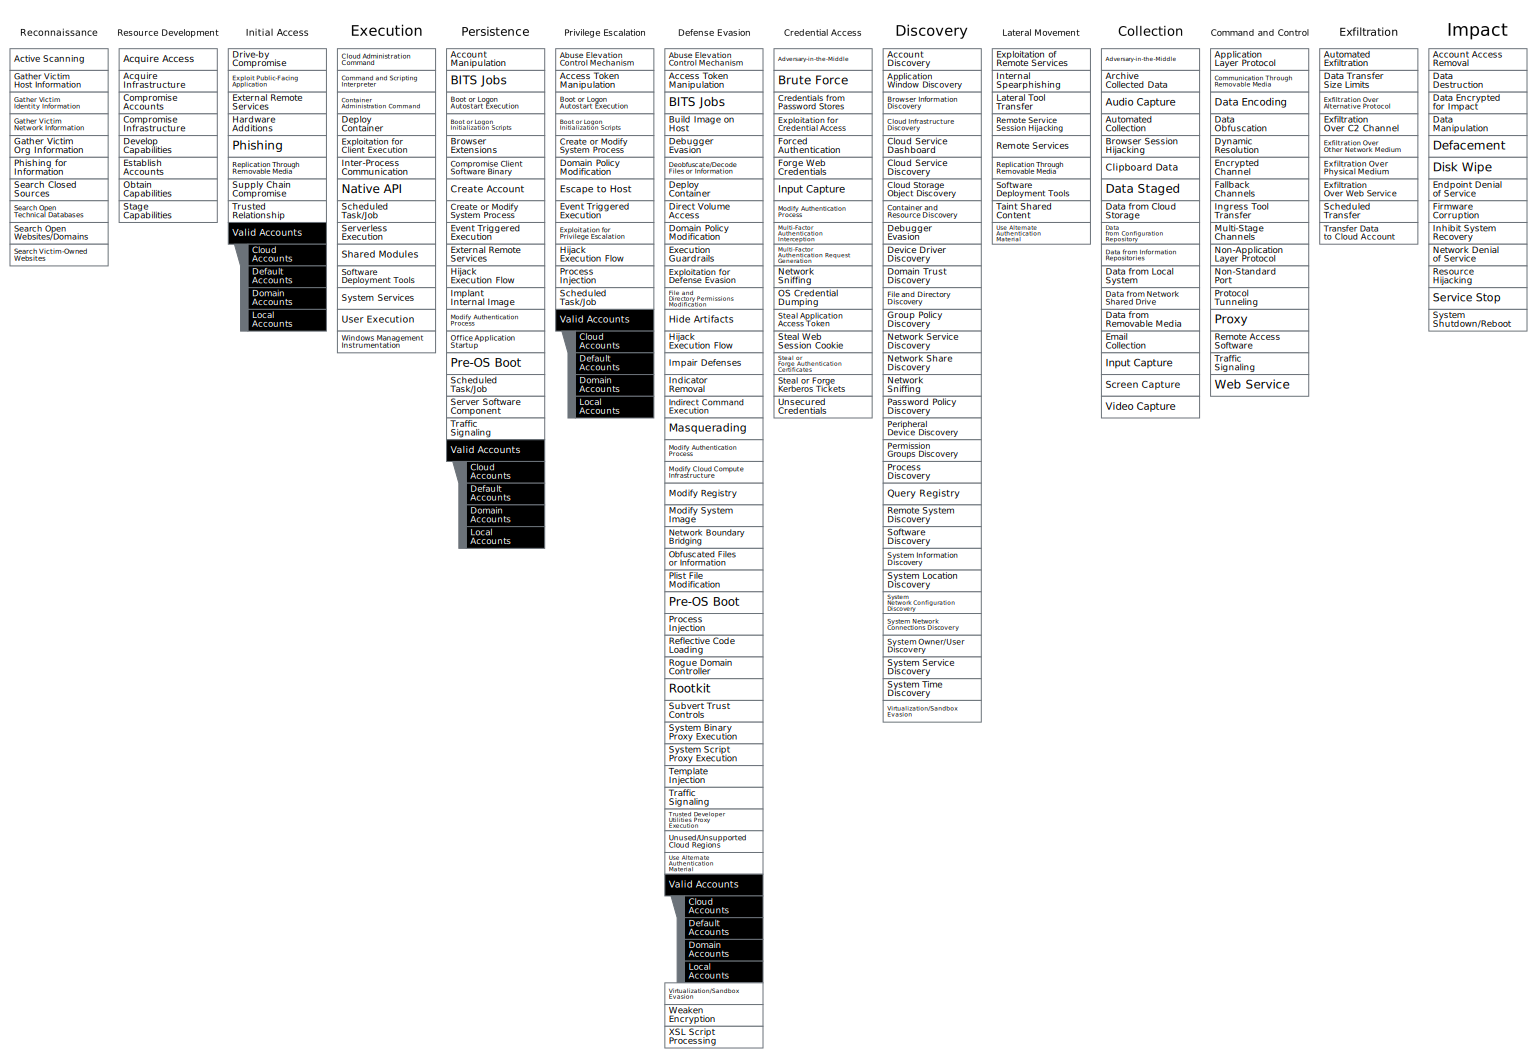

In [41]:
valid_accounts = techniques_df[techniques_df.ID.str.contains('T1078')][['ID', 'tactics']].to_dict('records')
create_layer(valid_accounts, "valid_accounts")
SVG(filename='svg/valid_accounts.svg')

# Execution

With everything we've done in mind, it is time to address the elephant in the room. If `Data Encoding` covers ever packet ever put into a network, the Execution Tactic collectively covers every single instruction ever executed by any processor. As such, we put forth the hypothesis that the `Execution` Tactic is collectively not detectable:

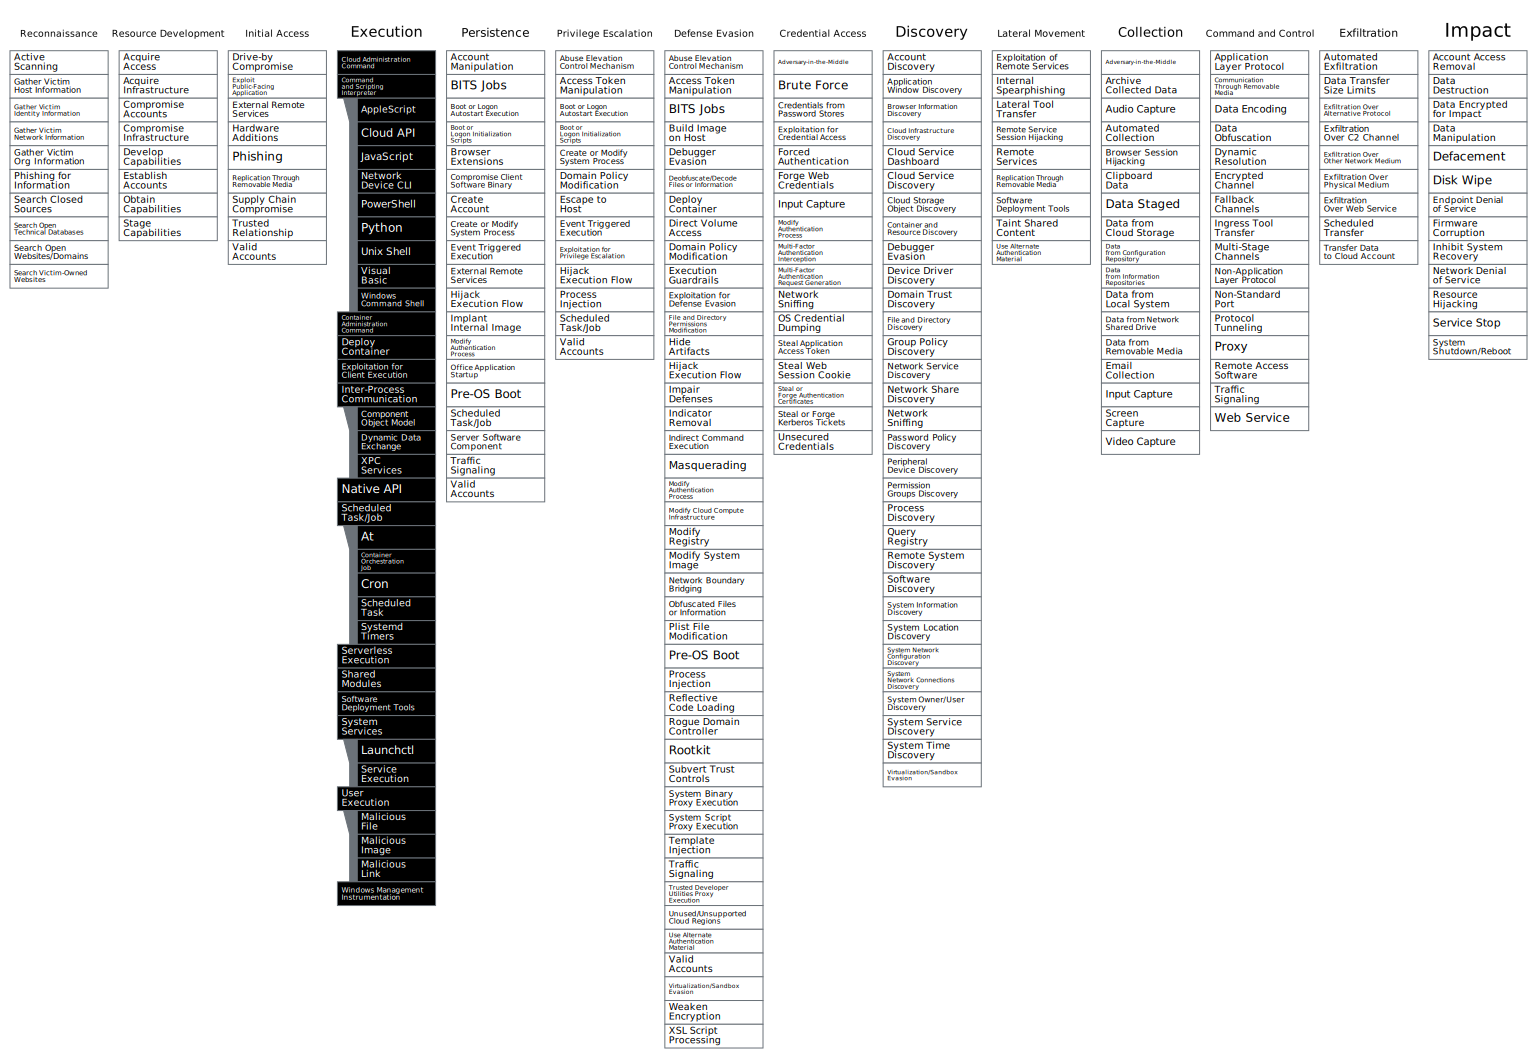

In [42]:
execution_ids = techniques_df[techniques_df.tactics.str.contains('Execution')].ID.to_list()
execution_techniques = techniques_df[techniques_df.tactics.str.contains('Execution')][['ID', 'tactics']].to_dict('records')
create_layer(execution_techniques, "execution_techniques")
SVG(filename='svg/execution_techniques.svg')


# Putting it all together

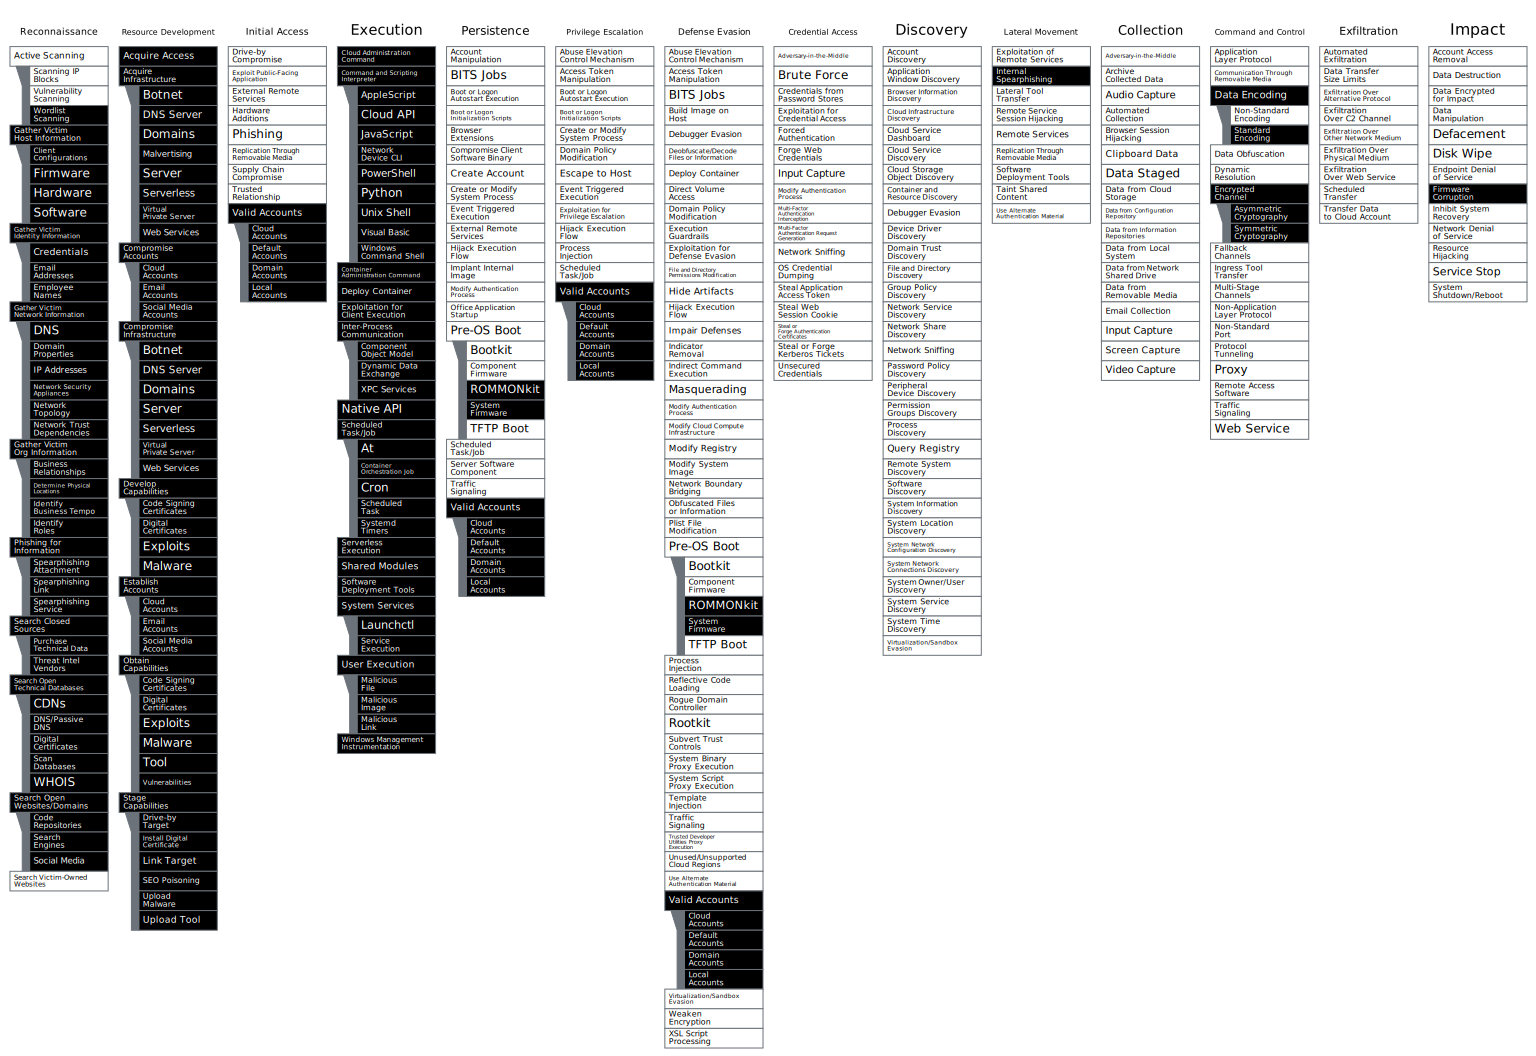

In [43]:
all_exclusions = techniques_with_no_data_sources + \
    techniques_with_uncollectable_data + \
    duplicated_phishing_techniques + \
    network_traffic_content_techniques + \
    execution_techniques + \
    firmware_techniques +\
    valid_accounts
create_layer(all_exclusions, "all_exclusions")
SVG(filename='svg/all_exclusions.svg')